In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from itertools import product

In [4]:
from codecarbon import EmissionsTracker

codecarbon_output = "./codecarbon_emissions.csv"

In [5]:
df = pd.read_csv('./pre_processed.csv', sep=';')
df = df.drop(columns='Unnamed: 0') 
df['timestamp'] = pd.to_datetime(df['DATA'] + ' ' + df['HORA'])

In [6]:
df.isna().sum()

DATA                                                         0
HORA                                                         0
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                          1234
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)     1008
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)           1037
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)          1037
RADIACAO GLOBAL (KJ/m²)                                  36778
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)              1010
TEMPERATURA DO PONTO DE ORVALHO (°C)                      4614
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                1040
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                1040
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)          4682
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)          4689
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                  4661
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                  4676
UMIDADE RELATIVA DO AR, HORARIA (%)                    

- como a preciptação é a principal variável, dropar todas as colunas onde a preciptação é NaN
- transformar todos os valores faltantesda coluna radiação em 0

In [7]:
df = df.dropna(subset=['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'])
df['RADIACAO GLOBAL (KJ/m²)'] = df['RADIACAO GLOBAL (KJ/m²)'].fillna(0)

In [8]:
columns_to_interpolate = df.select_dtypes(include=['float64']).columns

df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(limit_direction='both')

In [9]:
df.dtypes

DATA                                                             object
HORA                                                             object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)           float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                 float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                float64
RADIACAO GLOBAL (KJ/m²)                                         float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                    float64
TEMPERATURA DO PONTO DE ORVALHO (°C)                            float64
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)                float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)                float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        

In [10]:
df.isna().sum()

DATA                                                     0
HORA                                                     0
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         0
RADIACAO GLOBAL (KJ/m²)                                  0
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             0
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         0
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 0
UMIDADE RELATIVA DO AR, HORARIA (%)                      0
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                    

In [11]:
df

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp
18,2007-05-18,18:00,0.0,1010.0,1010.1,1010.0,100.8,23.5,21.1,23.8,23.5,21.2,21.1,87.0,85.0,86.0,224.0,6.4,4.6,2007-05-18 18:00:00
19,2007-05-18,19:00,0.0,1010.4,1010.4,1010.3,35.6,23.2,21.0,23.3,23.2,21.1,20.7,88.0,86.0,87.0,234.0,7.9,5.5,2007-05-18 19:00:00
35,2007-05-19,11:00,0.0,1013.2,1013.2,1013.1,91.2,23.6,19.3,23.6,23.1,19.3,18.2,77.0,74.0,77.0,37.0,2.0,0.4,2007-05-19 11:00:00
36,2007-05-19,12:00,0.0,1013.5,1013.5,1013.2,141.0,23.9,20.6,23.9,23.6,20.6,19.4,82.0,77.0,82.0,104.0,1.5,0.9,2007-05-19 12:00:00
37,2007-05-19,13:00,0.0,1013.8,1013.9,1013.8,428.8,25.0,19.3,25.0,24.3,19.5,19.0,74.0,71.0,71.0,239.0,5.4,3.9,2007-05-19 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101899,2018-12-31,19:00,0.0,1006.7,1006.7,1006.0,1410.0,27.8,23.4,28.6,27.4,23.8,22.9,78.0,73.0,77.0,130.0,8.0,6.6,2018-12-31 19:00:00
101900,2018-12-31,20:00,0.0,1006.6,1007.1,1006.6,637.0,26.7,23.4,27.8,26.3,23.6,22.8,83.0,77.0,82.0,129.0,9.1,4.3,2018-12-31 20:00:00
101901,2018-12-31,21:00,0.0,1007.2,1007.4,1006.6,302.5,26.1,22.8,26.8,26.1,23.4,22.8,82.0,82.0,82.0,103.0,5.4,2.1,2018-12-31 21:00:00
101902,2018-12-31,22:00,0.0,1007.5,1007.5,1007.2,41.5,25.7,22.8,26.2,25.7,22.9,22.6,84.0,82.0,84.0,135.0,3.3,1.5,2018-12-31 22:00:00


Classificar a chuva

In [12]:
def classify_precipitation(value):
    if value == 0:
        return "Sem chuva"
    elif value < 5.0:
        return "Chuva fraca"
    elif 5.0 <= value <= 25.0:
        return "Chuva moderada"
    elif 25.1 <= value <= 50.0:
        return "Chuva forte"
    elif value > 50.0:
        return "Chuva muito forte"

def combine_categories(classification):
    if classification in ["Chuva moderada", "Chuva forte", "Chuva muito forte"]:
        return f"Chuva moderada, forte \n ou muito forte"
    return classification

prec_class = df["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].apply(classify_precipitation)

prec_class.value_counts()

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)
Sem chuva            91569
Chuva fraca           8576
Chuva moderada         500
Chuva forte             23
Chuva muito forte        2
Name: count, dtype: int64

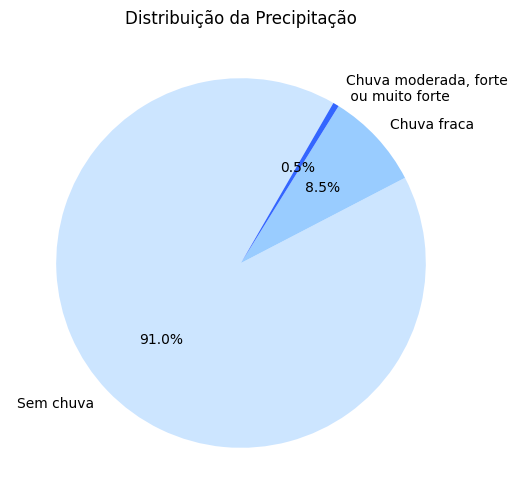

In [13]:
plt.figure(figsize=(6, 6))
prec_class.apply(combine_categories).value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=60,
    colors=["#cce5ff", "#99ccff", "#3366ff"]
)
plt.title("Distribuição da Precipitação")
plt.ylabel('') 
plt.savefig("grafico_pizza.png")
plt.show()

train and test split

In [14]:
X = df[df.columns.difference(['DATA', 'HORA', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'prec_class', 'timestamp'])]
y = df["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"]

In [15]:
X_train, X_test = X[:round(X.shape[0]*0.8)], X[round(X.shape[0]*0.8):]
y_train, y_test = y[:round(y.shape[0]*0.8)], y[round(y.shape[0]*0.8):]

# XGBoost preciptation

In [19]:
def train_xgboost(X_train, y_train, X_test, y_test, params):
    xgb_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
    
    predictions = xgb_model.predict(xgb.DMatrix(X_test))
    
    rmse = mean_squared_error(y_test, predictions)
    
    return xgb_model, predictions
    
def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    param_combinations = list(product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['min_child_weight']
    ))
    
    best_rmse = float('inf')
    best_params = None

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        max_depth, learning_rate, subsample, colsample_bytree, min_child_weight = combination
        params = {
            'max_depth': max_depth,
            'eta': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        model, predictions = train_xgboost(X_train, y_train, X_test, y_test, params)
        rmse = mean_squared_error(y_test, predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print("Best parameters found:")
    print(best_params)
    print(f"Best RMSE: {best_rmse}")
    
    final_model, final_predictions = train_xgboost(X_train, y_train, X_test, y_test, best_params)
    
    return final_model, final_predictions, best_params

In [20]:
tracker = EmissionsTracker(
    project_name="xgboost regression com tqdm",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

final_model, final_predictions, best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [01:17<00:00,  3.14it/s]

Best parameters found:
{'max_depth': 4, 'eta': 0.2, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 0.4766868223195054
emissions=3.5458134900428235e-05


### Resultados

In [21]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

evaluate_model(y_test, final_predictions)

MAE: 0.13036703636003183
MSE: 0.4766868223195054
MRSE: 0.690425102613966


/tmp/ipykernel_13310/1903075214.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2, label="Ideal Fit")


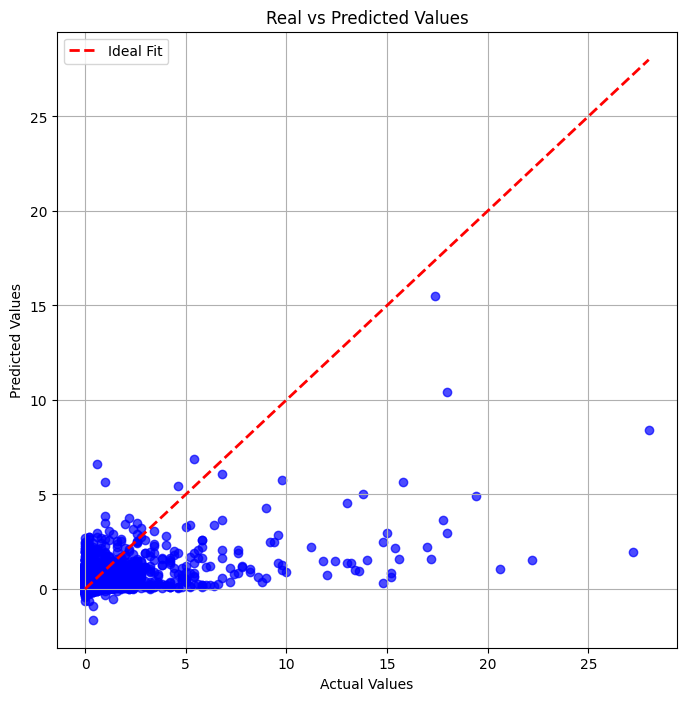

In [26]:
def plot_real_vs_predicted(y_test, predictions):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_real_vs_predicted(y_test, final_predictions)

In [49]:
def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

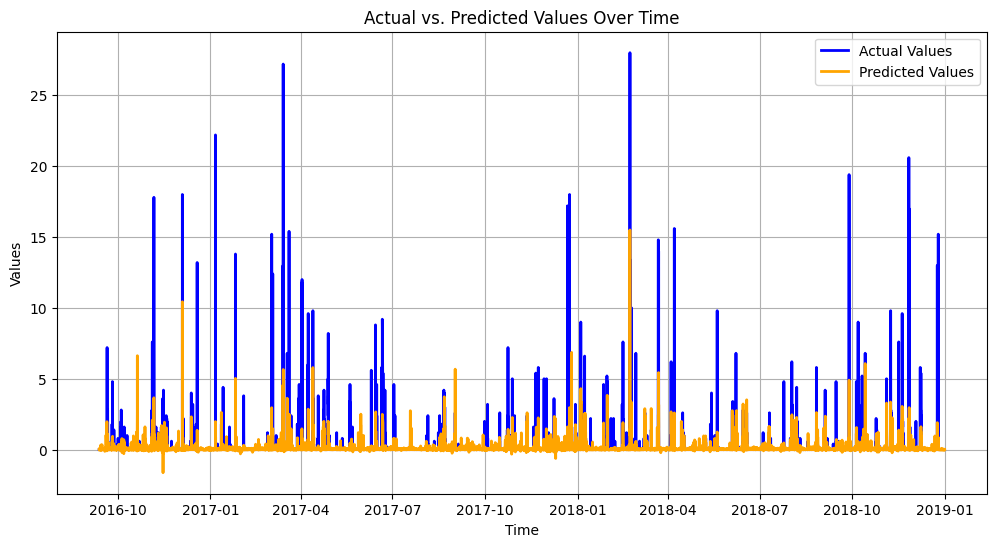

In [50]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test)

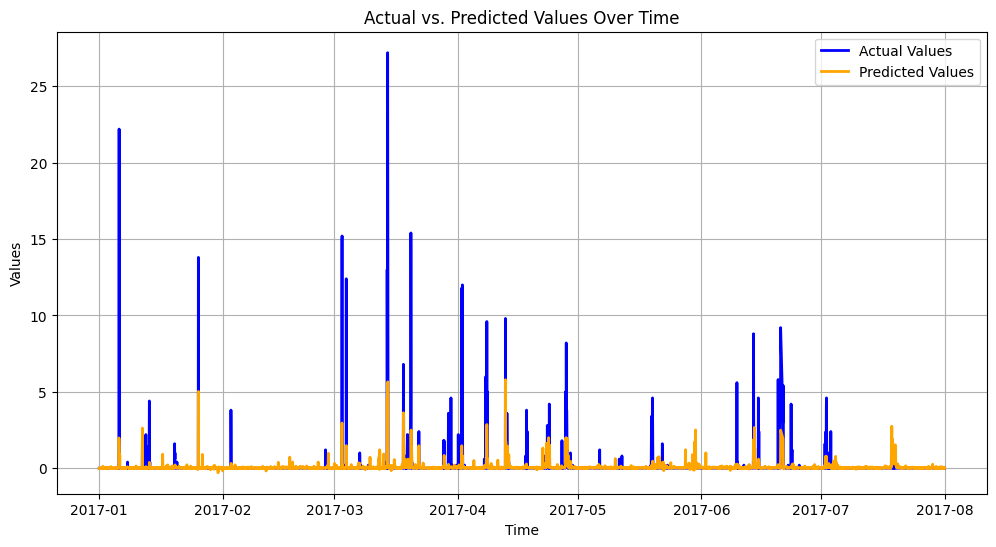

In [48]:
start_date = "2017-01-01"
end_date = "2017-08-01"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test, start_date, end_date)

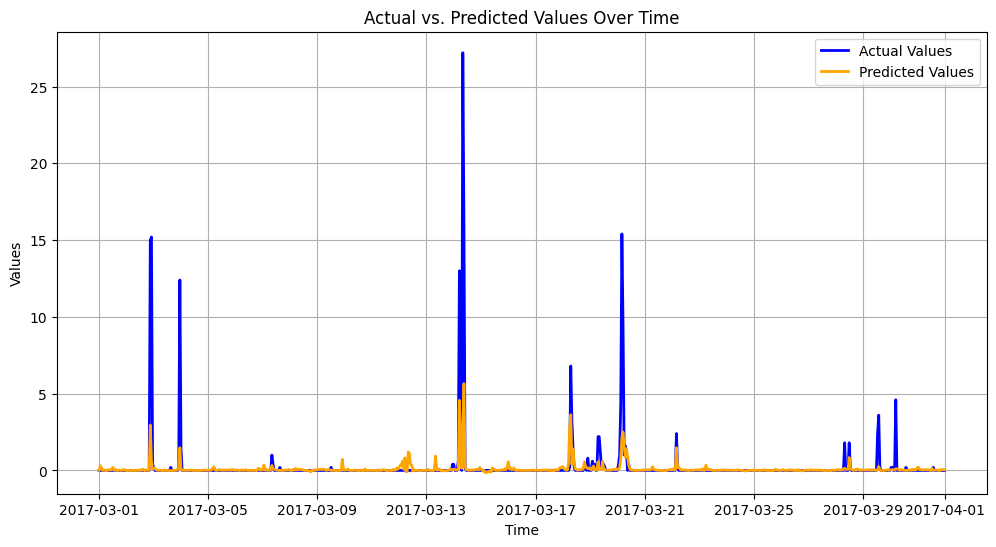

In [53]:
start_date = "2017-03-01"
end_date = "2017-04-01"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test, start_date, end_date)

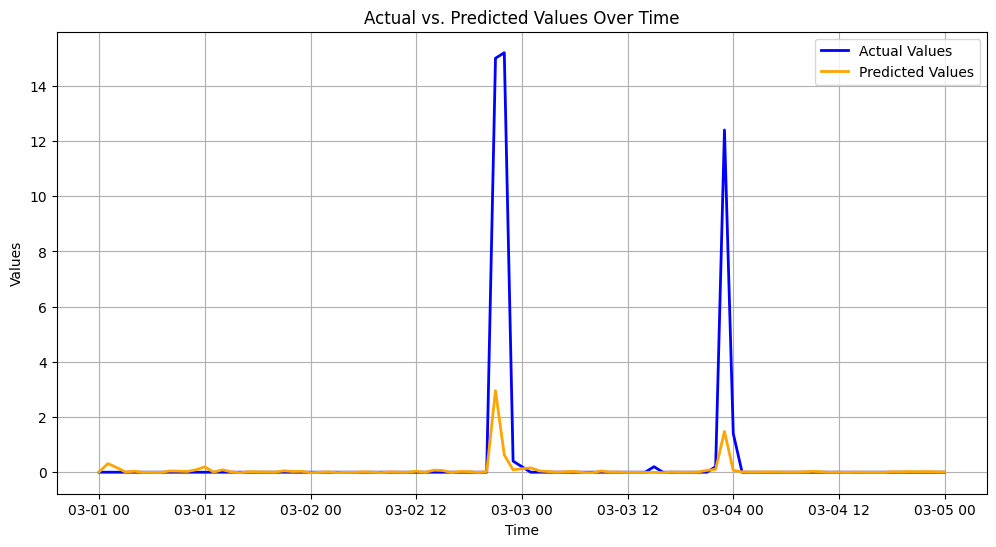

In [52]:
start_date = "2017-03-01"
end_date = "2017-03-05"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

plot_prediction_over_time(y_test, final_predictions, timestamps_test, start_date, end_date)

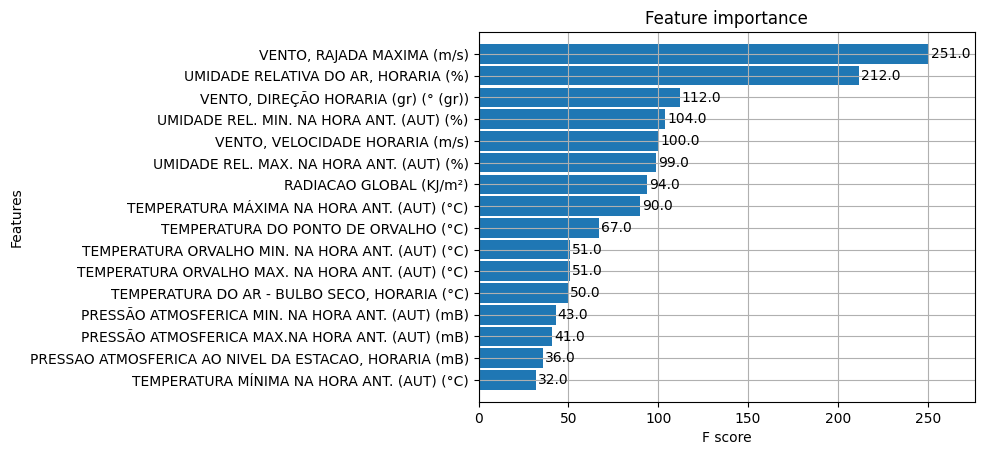

In [56]:
_ = plot_importance(final_model, height=0.9)

# XGBoost temperature

In [ ]:
tracker = EmissionsTracker(
    project_name="grid search xgboost temperature",
    output_file=codecarbon_output
)

tracker.start()

grid_search(X_train=X_train_temperature, y_train=y_train_temperature)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

In [ ]:
tracker = EmissionsTracker(
    project_name="treino com xgboost temperature",
    output_file=codecarbon_output
)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 1,
    'colsample_bytree': 1.0,
    'alpha': 0.2,
    'n_estimators': 300,
    'scale_pos_weigth': 1
  }

tracker.start()

xgb_model2, predictions2 = train_xgboost(X_train=X_train_temperature, X_test=X_test_temperature,y_test=y_test_temperature , y_train=y_train_temperature, params=params)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 00:56:23] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 00:56:23] [setup] RAM Tracking...
[codecarbon INFO @ 00:56:23] [setup] GPU Tracking...
[codecarbon INFO @ 00:56:23] No GPU found.
[codecarbon INFO @ 00:56:23] [setup] CPU Tracking...
[codecarbon WARNING @ 00:56:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 00:56:25] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 00:56:25] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 00:56:25] >>> Tracker's metadata:
[codecarbon INFO @ 00:56:25]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 00:56:25]   Python version: 3.10.12
[codecarbon INFO @ 00:56:25]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 00:56:25]   Available RAM : 12.675 GB
[codecarbon INFO @ 00:56:25]   CPU count: 2
[codecarbon INFO @ 00:56:25]   CP

RMSE: 0.31619503951556194
emissions=7.078574235973128e-05


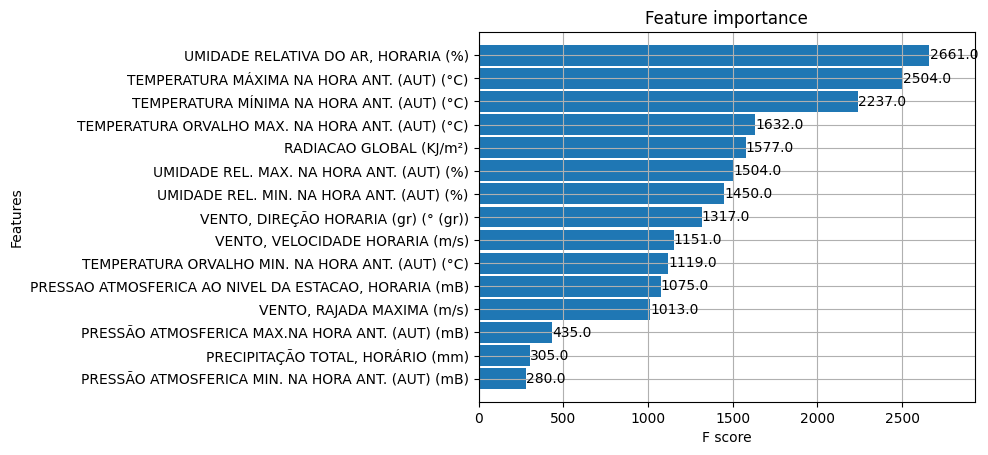

In [ ]:
_ = plot_importance(xgb_model2, height=0.9)

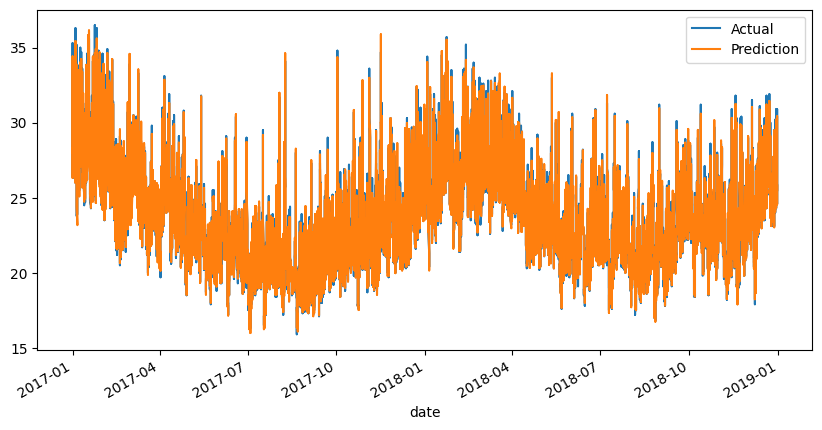

MAE: 0.21703392551587597
MSE: 0.09997930301424778
MRSE: 0.31619503951556194


In [ ]:
plot_predictions(testing_dates, y_test_temperature, predictions2)
evaluate_model(y_test_temperature, predictions2)

In [ ]:
tracker = EmissionsTracker(
    project_name="grid search xgboost humidity",
    output_file=codecarbon_output
)

tracker.start()

grid_search(X_train=X_train_humidity, y_train=y_train_humidity)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 01:01:39] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 01:01:39] [setup] RAM Tracking...
[codecarbon INFO @ 01:01:39] [setup] GPU Tracking...
[codecarbon INFO @ 01:01:39] No GPU found.
[codecarbon INFO @ 01:01:39] [setup] CPU Tracking...
[codecarbon WARNING @ 01:01:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 01:01:41] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 01:01:41] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 01:01:41] >>> Tracker's metadata:
[codecarbon INFO @ 01:01:41]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 01:01:41]   Python version: 3.10.12
[codecarbon INFO @ 01:01:41]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 01:01:41]   Available RAM : 12.675 GB
[codecarbon INFO @ 01:01:41]   CPU count: 2
[codecarbon INFO @ 01:01:41]   CP

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[codecarbon INFO @ 01:01:43] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 01:01:43] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:01:43] 0.005119 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:45] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 01:01:45] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:01:45] 0.005709 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:57] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 01:01:57] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:01:57] 0.000197 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:58] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 01:01:58] Energy consumed for a

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}
emissions=0.009870978014523859


In [ ]:
tracker = EmissionsTracker(
    project_name="treino com xgboost humidity",
    output_file=codecarbon_output
)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'alpha': 0.2,
    'n_estimators': 200,
    'scale_pos_weigth': 1
  }

tracker.start()

xgb_model3, predictions3 = train_xgboost(X_train=X_train_humidity, X_test=X_test_humidity,y_test=y_test_humidity , y_train=y_train_humidity, params=params)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 12:12:02] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 12:12:02] [setup] RAM Tracking...
[codecarbon INFO @ 12:12:02] [setup] GPU Tracking...
[codecarbon INFO @ 12:12:02] No GPU found.
[codecarbon INFO @ 12:12:02] [setup] CPU Tracking...
[codecarbon WARNING @ 12:12:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:12:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:12:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 12:12:03] >>> Tracker's metadata:
[codecarbon INFO @ 12:12:03]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 12:12:03]   Python version: 3.10.12
[codecarbon INFO @ 12:12:03]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 12:12:03]   Available RAM : 12.675 GB
[codecarbon INFO @ 12:12:03]   CPU count: 2
[codecarbon INFO @ 12:12:03]   CP

RMSE: 0.7984199600514277
emissions=1.3474954233603196e-05


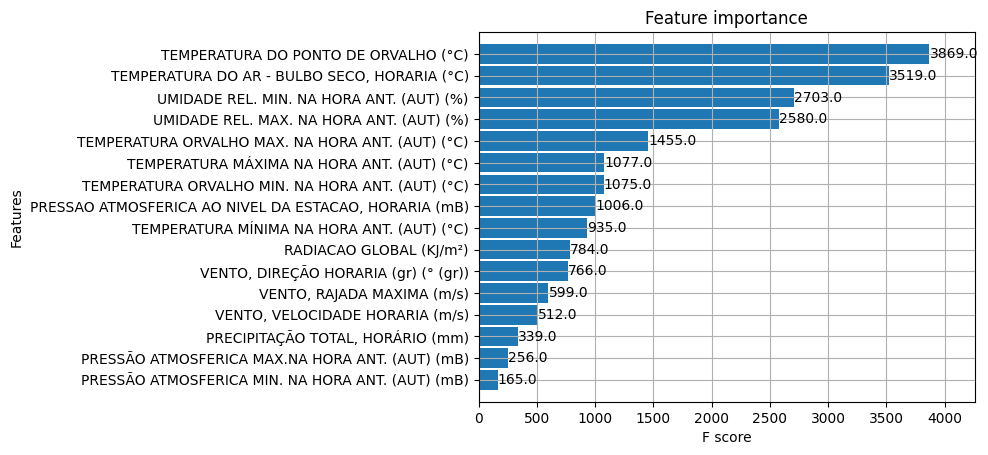

In [ ]:
_ = plot_importance(xgb_model3, height=0.9)

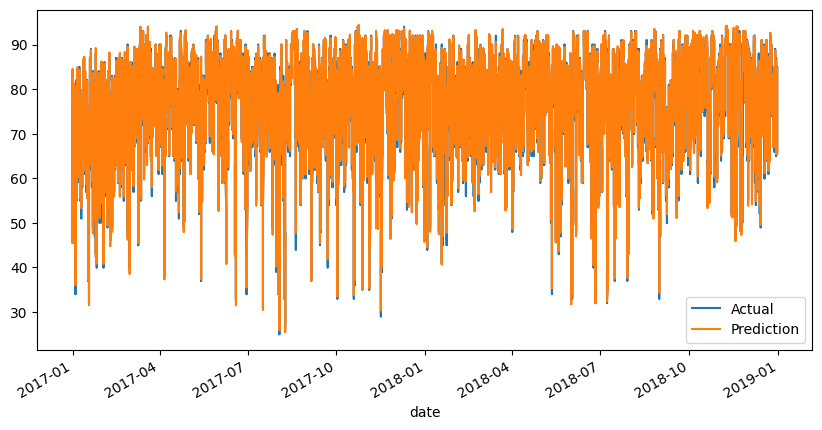

MAE: 0.6111281808725412
MSE: 0.6374744326085234
MRSE: 0.7984199600514277


In [ ]:
plot_predictions(testing_dates, y_test_humidity, predictions3)
evaluate_model(y_test_humidity, predictions3)

In [ ]:
tracker = EmissionsTracker(
    project_name="grid search xgboost radiation",
    output_file=codecarbon_output
)

tracker.start()

grid_search(X_train=X_train_radiation, y_train=y_train_radiation)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 12:13:17] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 12:13:17] [setup] RAM Tracking...
[codecarbon INFO @ 12:13:17] [setup] GPU Tracking...
[codecarbon INFO @ 12:13:17] No GPU found.
[codecarbon INFO @ 12:13:17] [setup] CPU Tracking...
[codecarbon WARNING @ 12:13:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:13:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:13:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 12:13:19] >>> Tracker's metadata:
[codecarbon INFO @ 12:13:19]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 12:13:19]   Python version: 3.10.12
[codecarbon INFO @ 12:13:19]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 12:13:19]   Available RAM : 12.675 GB
[codecarbon INFO @ 12:13:19]   CPU count: 2
[codecarbon INFO @ 12:13:19]   CP

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[codecarbon INFO @ 12:13:34] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 12:13:34] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:13:34] 0.000197 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:13:49] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 12:13:49] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:13:49] 0.000394 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:04] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 12:14:04] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:14:04] 0.000591 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:14:19] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753040313720703 W
[codecarbon INFO @ 12:14:19] Energy consumed for a

Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 1.0}
emissions=0.011030091069106381


In [ ]:
tracker = EmissionsTracker(
    project_name="treino com xgboost humidity",
    output_file=codecarbon_output
)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 8,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'alpha': 0.2,
    'n_estimators': 300,
    'scale_pos_weigth': 1
  }

tracker.start()

xgb_model4, predictions4 = train_xgboost(X_train=X_train_radiation, X_test=X_test_radiation,y_test=y_test_radiation , y_train=y_train_radiation, params=params)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 12:57:02] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 12:57:02] [setup] RAM Tracking...
[codecarbon INFO @ 12:57:02] [setup] GPU Tracking...
[codecarbon INFO @ 12:57:02] No GPU found.
[codecarbon INFO @ 12:57:02] [setup] CPU Tracking...
[codecarbon WARNING @ 12:57:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:57:04] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:57:04] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 12:57:04] >>> Tracker's metadata:
[codecarbon INFO @ 12:57:04]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 12:57:04]   Python version: 3.10.12
[codecarbon INFO @ 12:57:04]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 12:57:04]   Available RAM : 12.675 GB
[codecarbon INFO @ 12:57:04]   CPU count: 2
[codecarbon INFO @ 12:57:04]   CP

RMSE: 605.2382206393874
emissions=5.8368965268561046e-05


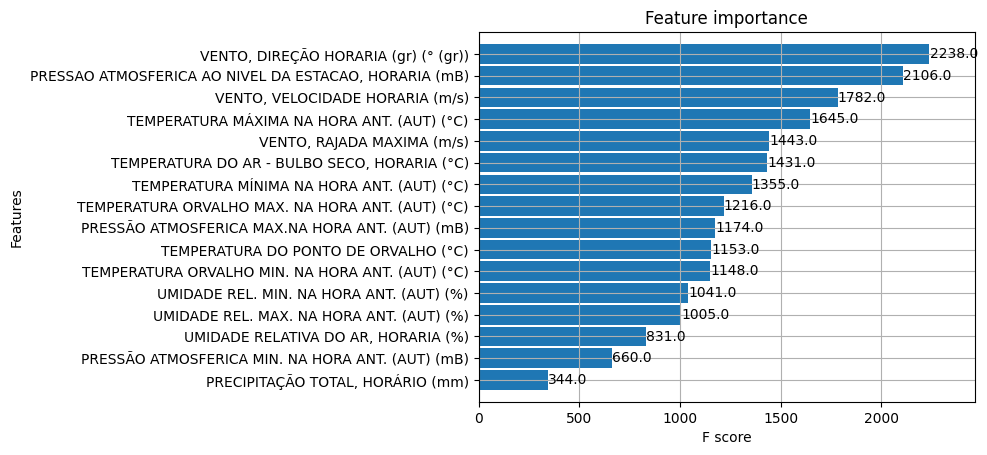

In [ ]:
_ = plot_importance(xgb_model4, height=0.9)

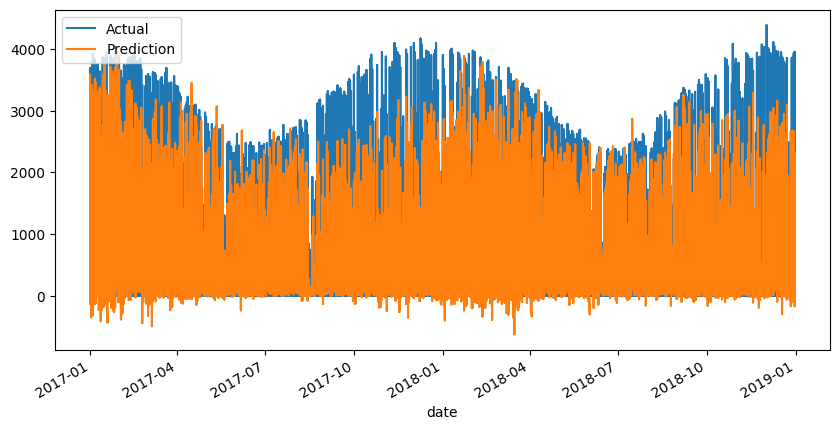

MAE: 402.3756129146643
MSE: 366313.30372273177
MRSE: 605.2382206393874


In [ ]:
plot_predictions(testing_dates, y_test_radiation, predictions4)
evaluate_model(y_test_radiation, predictions4)

# SVM

In [ ]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_train = y_train.fillna(0)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

def train_svm():
  model = SVR()

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  print(f'Mean Squared Error: {mse}')

  return model

In [ ]:
tracker = EmissionsTracker(
    project_name="treino com svm",
    output_file=codecarbon_output
)

tracker.start()

model = train_svm()

emissions: float = tracker.stop()
print(f"emissions={emissions}")

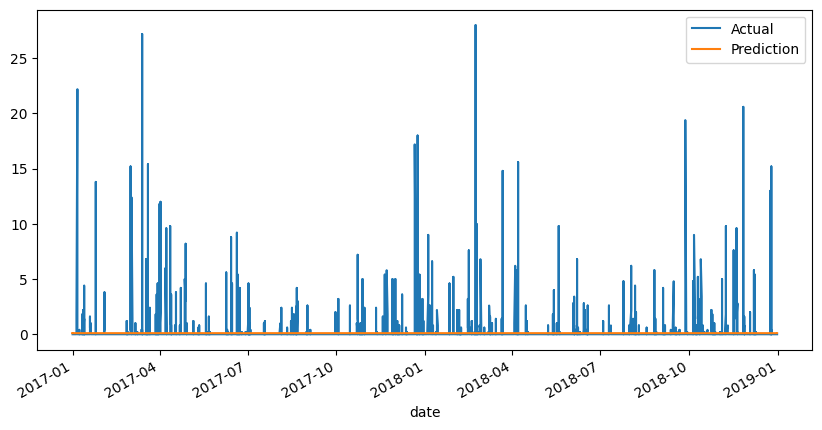

MAE: 0.19245089245521202
MSE: 0.6937662746913552
MRSE: 0.8329263320914733


In [ ]:
prediction = model.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

# Entendendo os dados

In [ ]:
df = df[df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] != 0]

idx_min_temp = df.groupby('Ano')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].idxmin()

dia_menos_quente = df.loc[idx_min_temp, ['Ano', 'DATA', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']]

print(dia_menos_quente)

        Ano       DATA  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)
1748   2007 2007-07-29                                          14.3
11744  2008 2008-09-18                                          15.7
19848  2009 2009-08-22                                          16.4
26934  2010 2010-06-13                                          16.1
36321  2011 2011-07-09                                          15.1
47010  2012 2012-09-26                                          15.7
54236  2013 2013-07-24                                          14.5
63488  2014 2014-08-14                                          15.0
71284  2015 2015-07-05                                          16.5
79545  2016 2016-06-13                                          15.1
89965  2017 2017-08-21                                          15.9
98863  2018 2018-08-27                                          16.8


In [ ]:
idx_max_temp = df.groupby('Ano')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].idxmax()

dia_mais_quente = df.loc[idx_max_temp, ['Ano', 'DATA', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']]
print(dia_mais_quente)

        Ano       DATA  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)
4023   2007 2007-11-01                                          37.3
5918   2008 2008-01-19                                          35.0
22335  2009 2009-12-03                                          35.5
24760  2010 2010-03-14                                          36.8
37574  2011 2011-08-30                                          35.1
46839  2012 2012-09-19                                          38.8
56894  2013 2013-11-12                                          37.9
66613  2014 2014-12-22                                          38.0
75592  2015 2015-12-31                                          37.8
77007  2016 2016-02-28                                          35.8
84953  2017 2017-01-24                                          36.5
93688  2018 2018-01-23                                          35.7


In [ ]:
df['UMIDADE RELATIVA DO AR, HORARIA (%)'].fillna(0, inplace=True)

idx_min_temp = df.groupby('Ano')['UMIDADE RELATIVA DO AR, HORARIA (%)'].idxmin()

dia_menos_quente = df.loc[idx_min_temp, ['Ano', 'DATA', 'UMIDADE RELATIVA DO AR, HORARIA (%)']]

print(dia_menos_quente)

        Ano       DATA  UMIDADE RELATIVA DO AR, HORARIA (%)
3107   2007 2007-09-24                                 17.0
11462  2008 2008-09-06                                 21.0
22513  2009 2009-12-11                                  0.0
23933  2010 2010-02-08                                  0.0
37573  2011 2011-08-30                                 22.0
46839  2012 2012-09-19                                 19.0
49336  2013 2013-01-01                                 34.0
63757  2014 2014-08-25                                 22.0
67070  2015 2015-01-10                                 24.0
80319  2016 2016-07-15                                 22.0
89537  2017 2017-08-03                                 25.0
97383  2018 2018-06-26                                 32.0


In [ ]:
idx_min_temp = df.groupby('Ano')['UMIDADE RELATIVA DO AR, HORARIA (%)'].idxmin()

dia_menos_quente = df.loc[idx_min_temp, ['Ano', 'DATA', 'UMIDADE RELATIVA DO AR, HORARIA (%)']]

print(dia_menos_quente)

        Ano       DATA  UMIDADE RELATIVA DO AR, HORARIA (%)
3107   2007 2007-09-24                                 17.0
11462  2008 2008-09-06                                 21.0
22515  2009 2009-12-11                                 24.0
27746  2010 2010-07-17                                 11.0
37573  2011 2011-08-30                                 22.0
46839  2012 2012-09-19                                 19.0
49336  2013 2013-01-01                                 34.0
63757  2014 2014-08-25                                 22.0
67070  2015 2015-01-10                                 24.0
80319  2016 2016-07-15                                 22.0
89537  2017 2017-08-03                                 25.0
97383  2018 2018-06-26                                 32.0


In [ ]:
resultados = []

for ano, grupo_ano in df.groupby('Ano'):
    media_temperaturas_por_mes = grupo_ano.groupby('Mês')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].mean()

    mes_mais_quente = media_temperaturas_por_mes.idxmax()

    media_mais_quente = media_temperaturas_por_mes.max()

    resultados.append({'Ano': ano, 'Mês': mes_mais_quente, 'Média de Temperatura': media_mais_quente})

resultados = pd.DataFrame(resultados)

resultados['Média de Temperatura'] = resultados['Média de Temperatura'].round(2)

print(resultados)

     Ano  Mês  Média de Temperatura
0   2007   12                 25.08
1   2008    2                 24.75
2   2009   11                 26.69
3   2010    1                 28.23
4   2011    1                 26.55
5   2012   12                 26.06
6   2013    2                 26.43
7   2014    1                 26.86
8   2015    1                 28.75
9   2016    2                 27.17
10  2017    1                 28.90
11  2018    3                 26.84


In [ ]:
resultados = []

for ano, grupo_ano in df.groupby('Ano'):
    media_temperaturas_por_mes = grupo_ano.groupby('Mês')['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].mean()

    mes_mais_frio = media_temperaturas_por_mes.idxmin()

    media_mais_fria = media_temperaturas_por_mes.min()

    resultados.append({'Ano': ano, 'Mês': mes_mais_frio, 'Média de Temperatura': media_mais_fria})

resultados = pd.DataFrame(resultados)

resultados['Média de Temperatura'] = resultados['Média de Temperatura'].round(2)

print(resultados)

     Ano  Mês  Média de Temperatura
0   2007    5                 21.03
1   2008    9                 21.20
2   2009    7                 21.18
3   2010    6                 21.28
4   2011    9                 20.47
5   2012    8                 21.01
6   2013    7                 21.02
7   2014    7                 21.14
8   2015    8                 21.40
9   2016    6                 20.15
10  2017    8                 20.42
11  2018    8                 20.87


Valores de correlação para a coluna 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':


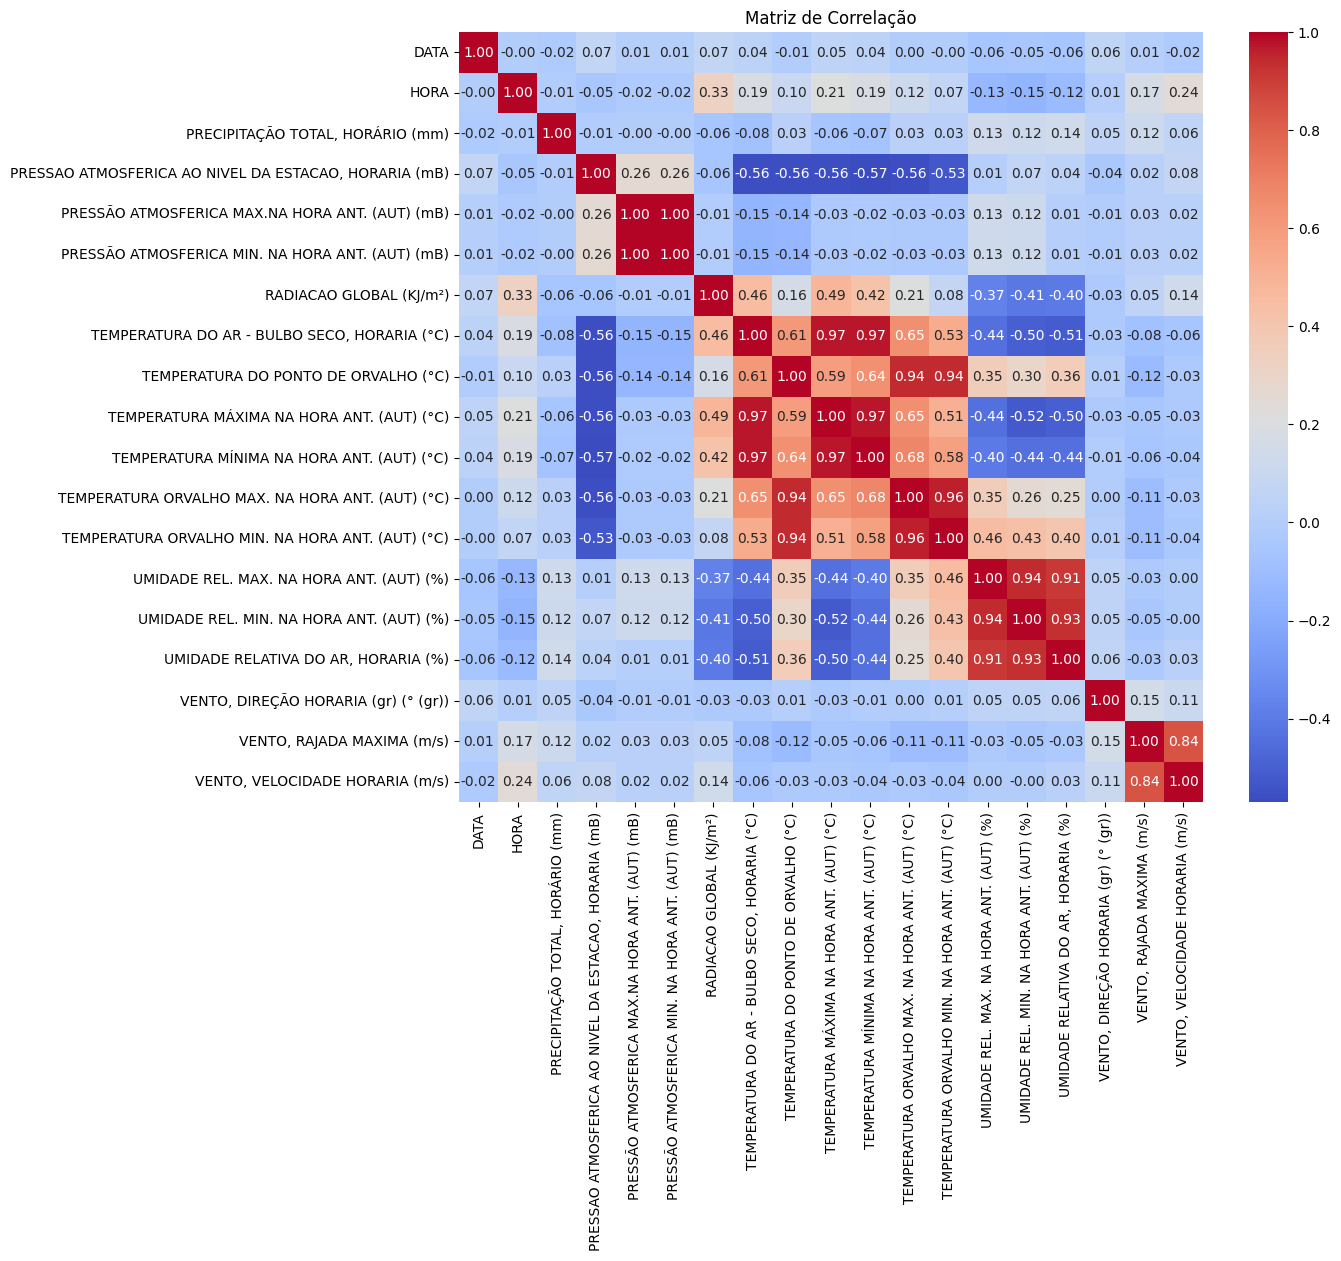

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.drop(columns=['Ano', 'Mês'])

correlation_matrix = df.corr()

correlation_matrix = correlation_matrix.round(2)
print("Valores de correlação para a coluna 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':")

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
correlacoes_temperatura = correlation_matrix['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']
print(correlacoes_temperatura)

DATA                                                     0.04
HORA                                                     0.19
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                        -0.08
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)   -0.56
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)         -0.15
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.15
RADIACAO GLOBAL (KJ/m²)                                  0.46
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             1.00
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0.61
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0.65
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         0.53
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                -0.44
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.50
UMIDADE RELATIVA DO AR, HORARIA (%)                     -0.51
VENTO, D

In [ ]:
temperatura_correlation = correlation_matrix['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

maiores_correlacoes_absolutas = temperatura_correlation.abs().sort_values(ascending=False)

maiores_correlacoes = maiores_correlacoes_absolutas[maiores_correlacoes_absolutas.index != 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

print("Maiores correlações com a temperatura:")
print(maiores_correlacoes)

Maiores correlações com a temperatura:
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0.97
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0.65
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0.61
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.56
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         0.53
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.51
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 0.50
RADIACAO GLOBAL (KJ/m²)                                  0.46
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.44
HORA                                                     0.19
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.15
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         0.15
VENTO, RAJADA MAXIMA (m/s)                               0.08
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         0.08
VENTO, VELOCIDADE HORARIA (m/s)

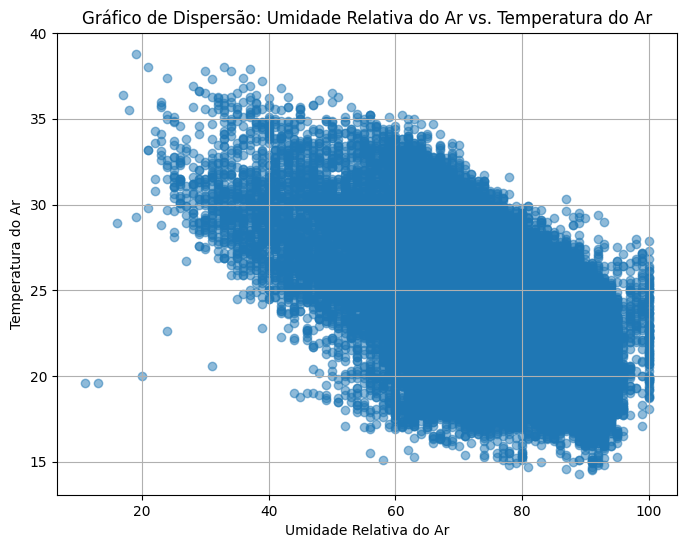

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['UMIDADE RELATIVA DO AR, HORARIA (%)'], df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], alpha=0.5)
plt.title('Gráfico de Dispersão: Umidade Relativa do Ar vs. Temperatura do Ar')
plt.xlabel('Umidade Relativa do Ar')
plt.ylabel('Temperatura do Ar')
plt.grid(True)
plt.show()